<center><h1>N1: Métodos de clustering</h1></center>

# N1.5: Métodos de clustering basados en modelos probabilísticos

En esta práctica vais a trabajar con los métodos de clustering basados en probabilidad vistos en clase. Concretamente, con el método basado en mixtura de Gaussianas y el algoritmo de EM (esperanza-maximización)

# RECUERDA RELLENAR TUS DATOS A CONTINUACIÓN ANTES DE HACER NADA

In [2]:
# ===============================================================#
# Rellena AQUÍ tu nombre y apellidos antes de hacer nada
# ===============================================================#

NOMBRE = 'Mayra'
APELLIDOS = 'Pullupaxi'

# ===============================================================#

Para empezar, cargamos las librerías que vamos a necesitar:

In [3]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from scipy.stats import multivariate_normal


Cargamos el dataset con el que vamos a trabajar:


El dataset cargado tiene 1999 instancias.


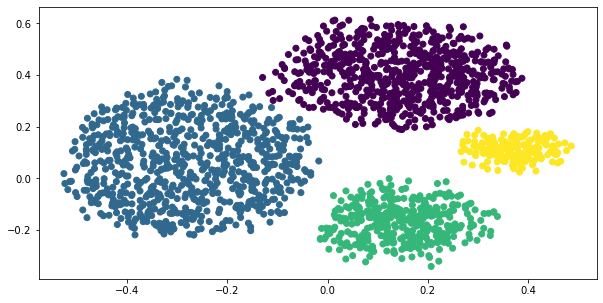

In [4]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_dos_guassianas.csv'
data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)


El algoritmo EM tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en inicializar el modelo. Se eligen unos centros iniciales de manera aleatoria, unas matrices de covarianzas fijas y unos pesos iniciales para las diferentes componentes. Sin más información, lo más normal sería asignar a todas las componentes el mismo peso.


In [5]:
######################## INICIALIZACION ########################
# Elegimos un número de clústeres a buscar
K = 4

# Asignar unas matrices de covarianzas iniciales
sigmas = []
for k in np.arange(K):
    sigmas.append( np.diag( 0.1 * np.ones( Dx.shape[1] ) ) )

x, y = np.mgrid[(np.min(Dx[:,0])-0.1):(np.max(Dx[:,0])+0.1):.01, 
                (np.min(Dx[:,1])-0.1):(np.max(Dx[:,1])+0.1):.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Inicialmente consideramos que todas las componentes tienen la misma probabilidad
PIs = np.ones(K)/K

In [6]:
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

# Elegir unos centros (uno para cada componente) de manera aleatoria
cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)

Los centros iniciales elegidos aleatoriamente son:
[[ 0.39193161  0.08184179]
 [-0.38532857 -0.04421144]
 [-0.41273228  0.48507912]
 [-0.21989207  0.16029928]]


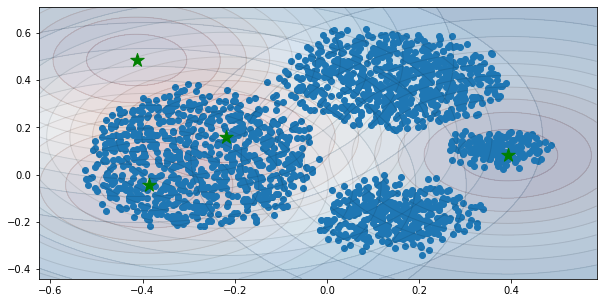

In [7]:
# Mostramos las componentes iniciales
fig, ax = plt.subplots(figsize=(10,5))
for k in np.arange(K):
    rv = multivariate_normal(mean=cDx[k,:], cov=sigmas[k])
    ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1,colors='k',alpha=0.1)
    ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)

ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')


Una vez inicializado, el algoritmo EM ejecuta un bucle donde se repiten los pasos E y M hasta que se alcanza la convergencia. 

En el paso E se (re)calcula la probabilidad de que cada ejemplo pertenezca a cada una de las componentes (los valores $z_{ik}$). 

En el paso M se (re)calculan los parámetros del modelo: los centros de las distribuciones normales (uno por componente, $\mu_k$), las matrices de covarianzas de las normales (una por componente, $\Sigma_k$) y los coeficientes de importancia de las diferentes componentes ($\{\pi_k\}_{k=1}^K$, con $\sum_k \pi_k=1$).

El algoritmo alcanza la convergencia cuando los parámetros no cambian entre dos iteraciones consecutivas.


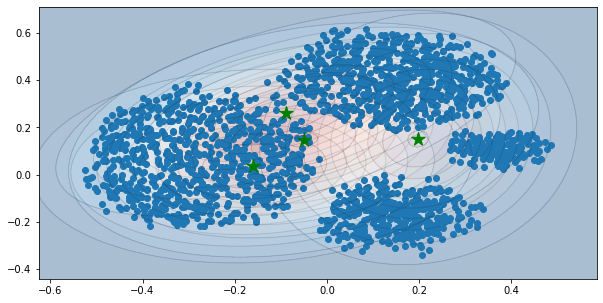

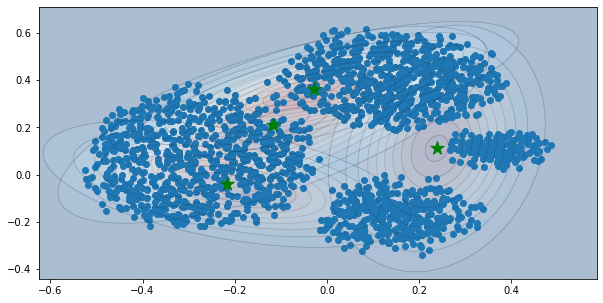

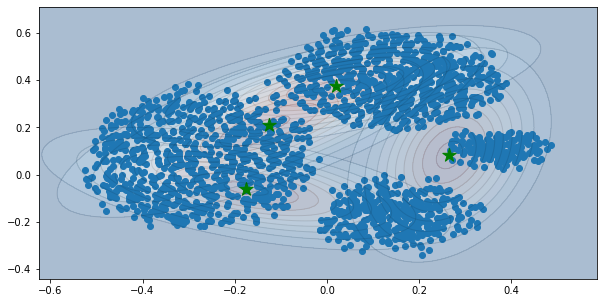

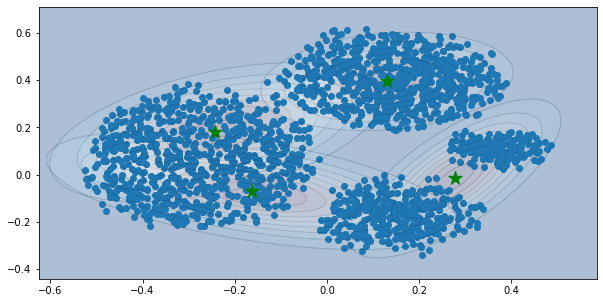

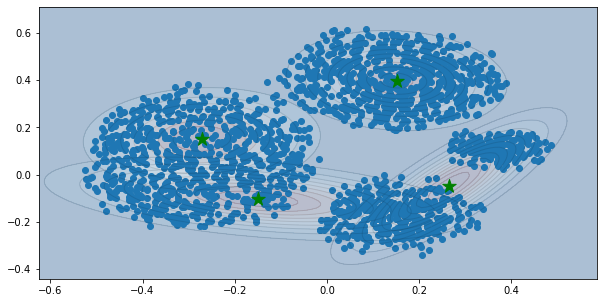

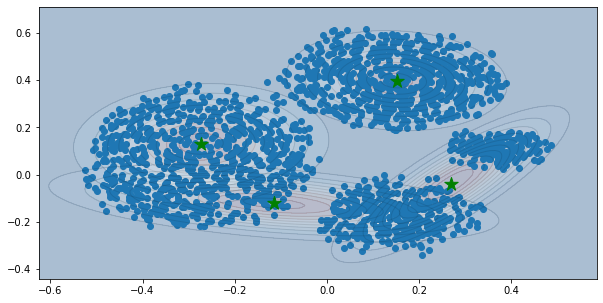

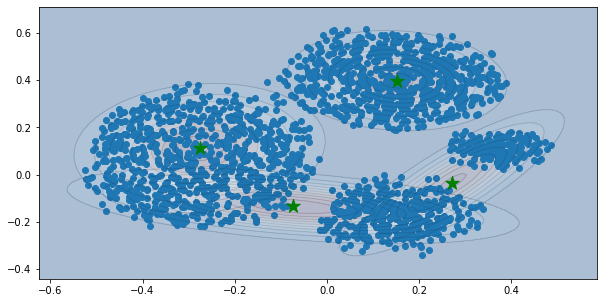

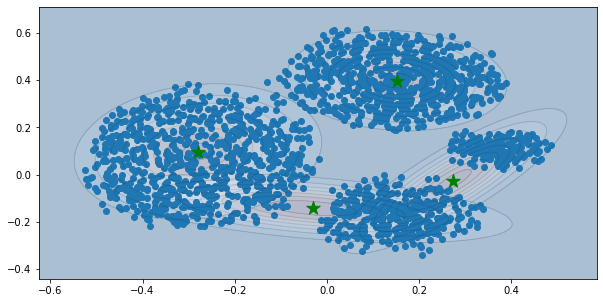

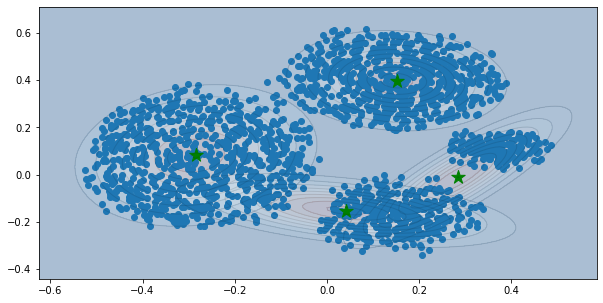

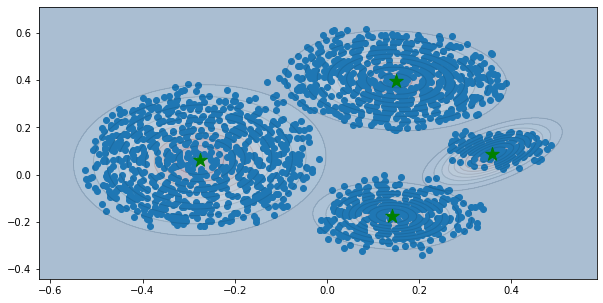

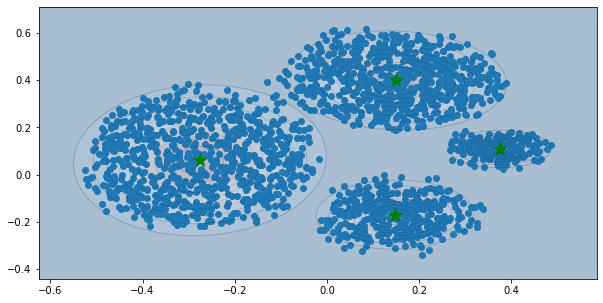

In [8]:
# Preparamos el vector donde guardamos la asignación probabilística 
# de cada elemento a un clúster (z_ik)
Dy_probs = np.zeros((Dx.shape[0], K))

# Flag de convergencia
iterando = True
# Dibujar los plots intermedios?
dibujar = True
# Si dibujas, sólo uno de cada 'frec_dibujo'
frec_dibujo = 10

it = 0

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    
    # PASO E:
    # Calcular la asignacion a las componentes (z_ik)
    for k in np.arange(K):
        Dy_probs[:,k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k,:], cov=sigmas[k])
    Dy_probs = Dy_probs/np.sum(Dy_probs,axis=1)[:,None]
    
    # PASO M:
    # - a: Calcular los nuevos centros de las K componentes
    for k in range(K):
        cDx[k,:] = np.sum(Dy_probs[:,k,None]*Dx,axis=0)/np.sum(Dy_probs[:,k])

    # - b: Calcular la matriz de covarianza (sigma) de las K componentes
    for k in range(K):
        sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(Dx[i,:,None]-cDx[k,:,None],
                                                  (Dx[i,:,None]-cDx[k,:,None]).transpose())
                            for i in np.arange(Dx.shape[0])], axis=0) / np.sum(Dy_probs[:,k])

    # - c: Calcular los coeficientes de importancia de las diferentes componentes
    PIs = np.sum(Dy_probs,axis=0)/Dx.shape[0]

    if dibujar and (it % frec_dibujo) == 0:
        # Dibujar el plot con el resultado actual
        fig, ax = plt.subplots(figsize=(10,5))
        for k in np.arange(K):
            rv = multivariate_normal(mean=cDx[k,:], cov=sigmas[k])
            ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1,colors='k',alpha=0.1)
            ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)
        ax.scatter(Dx[:,0],Dx[:,1])
        ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')

    it += 1
    if np.allclose(cDx, cDx_ant):
        break
            


El resultado final del algoritmo es una matriz de probabilidades que asigna cada elemento a un clúster (componente) con cierta probabilidad. Si quisiésemos obtener una asignación determinista de cada caso a un único clúster, tomaríamos la componente que mayor probabilidad asigna a cada caso como su clúster:


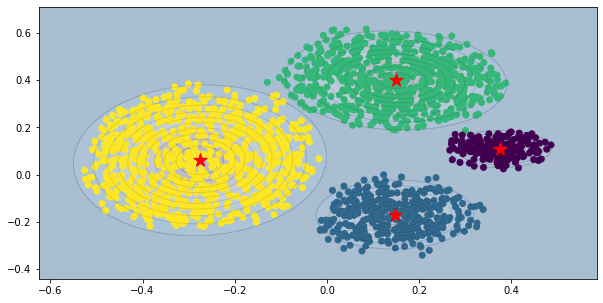

In [9]:
Dyp = np.argmax(Dy_probs,axis=1)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
for k in np.arange(K):
    rv = multivariate_normal(mean=cDx[k,:], cov=sigmas[k])
    ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1,colors='k',alpha=0.1)
    ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

In [ ]:
# Como podéis observar, sólo hay un punto que se asigna de manera incorrecta a otro clúster. 

# P1. ¿Cuales créeis que serán las probabilidades aproximadas de dicho punto para cada una de las componentes?

# a) Amarillo=0.02. Verde=0.42. Morado: 0.48. Azul: 0.08.
# b) Amarillo=0.02. Verde=0.48. Morado: 0.42. Azul: 0.08.
# c) Amarillo=0.02. Verde=0.7. Morado: 0.2. Azul: 0.08.

# SE DEBE CONTESTAR EN EL CAMPUS VIRTUAL

# P2. En ese caso concreto, ¿a qué puede deberse el error?

# a) La (co)varianza de la componente a la que realmente pertenece es más pequeña que la de la otra (a la que al final es asignado)
# b) La (co)varianza de la componente a la que realmente pertenece es más grande que la de la otra (a la que al final es asignado)
# c) La (co)varianza de las diferentes componentes no influye en la asignación, sino que es la incialización aleatoria lo que propicia este resultado

# SE DEBE CONTESTAR EN EL CAMPUS VIRTUAL

# P3. ¿Existe alguna forma de obtener un resultado diferente, o el algoritmo siempre encontrará el mismo resultado?

# a) El algoritmo es determinista, por lo que siempre obtendrá los mismos resultados
# b) Podemos variar los parámetros de las gaussianas para que tengan distintas formas
# c) Podemos variar la inicialización para que el resultado final sea diferente

# SE DEBE CONTESTAR EN EL CAMPUS VIRTUAL


Como en anteriores ocasiones, podemos estudiar la bondad del agrupamiento ya que se conoce la realidad:


In [10]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))

[[  0   0 686   4]
 [  0   0   0 783]
 [  0 358   0   0]
 [167   0   1   0]]
El valor del error cometido es =  0.002501250625312701
La pureza del agrupamiento obtenido es =  0.9974987493746873
El valor F1 es =  0.997497827104049


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo EM para mixturas de Gaussianas. 

Matriz de confusión:
[[  0 686   0   4]
 [408   0   0 375]
 [  2   0 356   0]
 [  0   0 168   0]]
El valor del error cometido es =  0.19059529764882444
La pureza del agrupamiento obtenido es =  0.9129564782391196
El valor F1 es =  0.7974628798724737


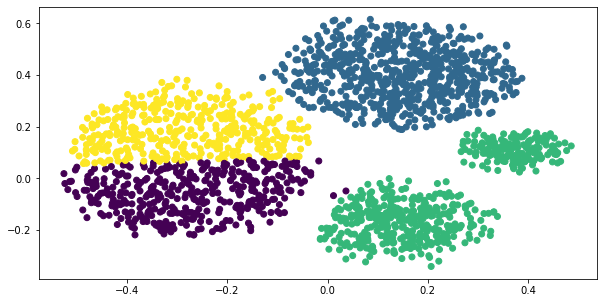

In [11]:
from sklearn.mixture import GaussianMixture

# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(Dx)

# Medimos el rendimiento del algoritmo de ScikitLearn
mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)



El algoritmo anterior, ejecutado a la primera, puede dar un resultado no óptimo: se está eligiendo una inicialización que encalla en un óptimo local. Si se ejecuta en varias ocaciones, eventualmente se obtendrá el resultado óptimo.

Podríamos comparar el resultado de nuestro algoritmo y el de la implementación de ScikitLearn para observar si devuelven el mismo resultado:
    

In [12]:

# Si comparamos el resultado de ambos algoritmos, el nuestro y el de ScikitLearn
mC_comp = matriz_confusion(Dyp,Dyp_sk)

print('Matriz de confusión:')
print(mC_comp)
print('El valor del error cometido es = ', medida_error(mC_comp))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_comp))
print('El valor F1 es = ', medida_f1(mC_comp))

Matriz de confusión:
[[  0   0 167   0]
 [  2   0 356   0]
 [  0 686   1   0]
 [408   0   0 379]]
El valor del error cometido es =  0.19109554777388693
La pureza del agrupamiento obtenido es =  0.9149574787393697
El valor F1 es =  0.7967580370377776
